# Mutational pattern from UKB mutations

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from io import StringIO
import seaborn as sns
import scipy.stats as stats
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 40)
%precision 2


import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

# Select mutations

In [3]:
### Read data ch mutations and age (NOT PROVIDED)
# Created in section 1_Post_processing_calling
patient_age_ch = pd.read_csv('../1_Post_processing_calling/patient_450k_age_670124_ALL_MUTATIONS_20230802_v3.txt.gz',sep="\t")
print(f'Patients:{len(patient_age_ch)}')
print(f'Columns:{list(patient_age_ch.columns)}')

Patients:469880
Columns:['patient', 'age_recruitment', 'age_group', 'CH_driver', 'CH_driver_big', 'CH_driver_small', 'CH_potential', 'CH_passengers', 'num_CH_drivers', 'CH_driver_multiple', 'num_CH_potential', 'ASXL1_driver', 'ASXL1_passenger', 'ASXL1_potential', 'CHEK2_driver', 'CHEK2_passenger', 'CHEK2_potential', 'DNMT3A_driver', 'DNMT3A_passenger', 'DNMT3A_potential', 'GNAS_driver', 'GNAS_passenger', 'GNAS_potential', 'IDH2_driver', 'IDH2_passenger', 'IDH2_potential', 'MDM4_driver', 'MDM4_passenger', 'MDM4_potential', 'PPM1D_driver', 'PPM1D_passenger', 'PPM1D_potential', 'SF3B1_driver', 'SF3B1_passenger', 'SF3B1_potential', 'SRSF2_driver', 'SRSF2_passenger', 'SRSF2_potential', 'TET2_driver', 'TET2_passenger', 'TET2_potential', 'TP53_driver', 'TP53_passenger', 'TP53_potential', 'U2AF1_driver', 'U2AF1_passenger', 'U2AF1_potential', 'chromatin_gene_driver', 'DDR_gene_driver', 'splicing_gene_driver', 'chromatin_gene_passenger', 'DDR_gene_passenger', 'splicing_gene_passenger', 'chromati

In [4]:
### Upload UKB mutations (NOT PROVIDED)
# Created in section 1_Post_processing_calling
boostDM_predictions = pd.read_csv('../1_Post_processing_calling/All450k_filtered_boostDM_ALL_age_20230802_v3.vcf', sep="\t", compression='gzip')
boostDM_predictions = boostDM_predictions.rename(columns={'case': 'patient', 'BoostDM':'Drivers_12genes'})
boostDM_predictions = boostDM_predictions[~boostDM_predictions['Prot_pos'].isna()]
boostDM_predictions = boostDM_predictions[~boostDM_predictions['Consequence'].isin(['start_lost', 'stop_lost', 'stop_retained_variant'])]
boostDM_predictions = boostDM_predictions[boostDM_predictions['patient'].isin(patient_age_ch['patient'])]
boostDM_predictions = boostDM_predictions[~boostDM_predictions['ALT'].str.contains(',')]
len(boostDM_predictions)

203351

In [5]:
#Remove those mutations from cases with previous hematological cancer

# Upload general cancer information per case (NOT PROVIDED)
# Created in section 0_Clinical_phenotypes
patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb450k_670124.txt.gz', sep="\t")
ukb200K_ch_cancer = pd.merge(patient_age_ch, patient_cancer,  how='inner', on='patient')

# Upload Cancer variables per case (NOT PROVIDED)
# Created in section 0_Clinical_phenotypes
patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb200k_Siddharta_670124_simple.txt.gz', sep="\t")
patient_cancer = patient_cancer.rename(columns={'eid': 'patient'})
ukb200K_ch_cancer = pd.merge(ukb200K_ch_cancer, patient_cancer,  how='inner', on='patient')
ukb200K_ch_cancer.rename(columns={'CH_passengers':'CH_nonDriver'}, inplace=True)

# Create a unique variable for hematological cancer
yeears = ['var_MM_years', 'var_MPN_years', 'var_MDS_years', 'var_CMML_years',
          'var_AML_years', 'var_LL_years', 'var_Lymphoma_years', 'var_Myeloma_years']
ukb200K_ch_cancer['var_HNALL_years'] = ukb200K_ch_cancer.loc[:,yeears].min(axis=1)
ukb200K_ch_cancer['var_HNALL_var'] = np.where(ukb200K_ch_cancer['var_HNALL_years'].notnull(), 1, 0)
ukb200K_ch_cancer['var_HNALL_post'] = np.where(ukb200K_ch_cancer['var_HNALL_years'] > 0, 1, 0)
ukb200K_ch_cancer['var_HNALL_pre'] = np.where(ukb200K_ch_cancer['var_HNALL_years'] < 0, 1, 0)

# Select only those mutations from patients without a previoius hematological cancer
non_HN_patients = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]['patient'].tolist()
boostDM_all = boostDM_predictions[boostDM_predictions['patient'].isin(non_HN_patients)]
len(boostDM_all)

/tmp/jobs/jramis/9874679/ipykernel_49487/1462063630.py:4: DtypeWarning: Columns (36,37,38,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb450k_670124.txt.gz', sep="\t")


201857

# Generate mutation matrix with the flanking nucleotide context

In [9]:
from Bio import SeqIO

In [7]:
# read the GRCh38 fasta file (NOT PROVIDED)
ref_genome_file = '/mnt/project/analysis/refs/GRCh38.d1.vd1.fa'
sequences = [i for i in SeqIO.parse(ref_genome_file, 'fasta')]

In [8]:
def get_nt(row):
    nt = str([chrom for chrom in sequences if chrom.name == 'chr'+str(row['#CHROM'])][0].seq[int(row['POS'])-2:int(row['POS']+1)])
    return nt

In [6]:
from tqdm import tqdm
tqdm.pandas()
boostDM_all['ref_biopy'] = boostDM_all.progress_apply(lambda x: get_nt(x), axis=1)

In [13]:
# Check annotation 
count=0
for i in boostDM_all.index.tolist():
    if boostDM_all.loc[i,'REF'] == boostDM_all.loc[i,'ref_biopy'][1]:
        count+=1
count

201857

In [14]:
# Save file
boostDM_all.to_csv("boostDM_all_context_nonHNALL.txt.gz", sep="\t", index=False, compression='gzip')

# Generate plots

In [7]:
boostDM_all = boostDM_all[~boostDM_all['ALT'].str.contains(',')]
non_HN_patients = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]['patient'].tolist()
boostDM_all = boostDM_all[boostDM_all['patient'].isin(non_HN_patients)]

In [18]:
boostDM_all.ALT.value_counts()

A    90320
T    69040
C    21709
G    20788
Name: ALT, dtype: int64

In [19]:
boostDM_drivers = boostDM_all[boostDM_all['Drivers_12genes']==1]
print(len(boostDM_drivers))
boostDM_non = boostDM_all[boostDM_all['Drivers_12genes']==0]
print(len(boostDM_non))

41306
160551


# 96 channel count matrix

In [20]:
from itertools import product

CB = dict(zip(list('ACGT'), list('TGCA')))

def mut_key_generator():
    """
    Returns:
        Generates all possible lexicographic pairs
            1st component: substitution;
            2nd component: flanks
    """
    subs = ['CA', 'CG', 'CT', 'TA', 'TC', 'TG']
    for s in sorted(subs):
        for c in sorted(product({'A', 'C', 'G', 'T'}, repeat=2)):
            yield tuple([s, ''.join(c)])


def shortkey_to_lex(key):
    """
    Args:
        key: signature key in short key format
    Returns:
        tuple representing a lexicographic pair key
    """
    t1 = ''.join([key[1], key[-1]])
    t2 = ''.join([key[0], key[2]])
    return tuple([t1, t2])


def complementary(key):
    """
    Args:
        key: short key format
    Returns:
        DNA complementary in short key format
    """
    ref = key[1]
    alt = key[-1]
    ctxt = (key[0], key[2])
    return ''.join([CB[ctxt[1]], CB[ref], CB[ctxt[0]], '>', CB[alt]])

def mut_keys():
    """generator of signature channels in lexicographic order"""
    for change, context in mut_key_generator():
        yield context[0] + change[0] + context[1] + '>' + change[1]
    

class dNdSOut:

    def __init__(self, annotmuts_fn):

        self.annotmuts = annotmuts_fn.copy()

    @staticmethod
    def pyr_context(row):
        """pyr-context associated to row in maf table"""

        context = row['ref_biopy'] + '>' + row['ALT']
        if context[1] not in list('CT'):
            context = complementary(context)
        return context

    def catalogue(self):
        """96 channel count matrix"""
        
        # exclude mutations in any driver genes
#         df = self.annotmuts[~self.annotmuts['gene'].isin(genes12)].copy()
        
        # select SNVs
#         df = self.annotmuts[(self.annotmuts['ref'].isin(list('ACGT'))) & (self.annotmuts['alt'].isin(list('ACGT')))].copy()
        df = self.annotmuts.copy()
        
        # create context for each SNV
        df.loc[:, 'context'] = df.apply(self.pyr_context, axis=1)
        
        # count SNVs per context
        dg = df.groupby('context').agg('count')
#         catalogue = dg.loc[list(mut_keys()), 'sampleID'].tolist()
        catalo = []
        for x in list(mut_keys()):
            if x in dg.index.tolist():
                catalo.append(dg.loc[x,'patient'])
            else:
                catalo.append(0)
        
        return catalo
    

def minor_tick_labels():
    
    major_labels = ['C>A', 'C>G', 'C>T', 'T>A', 'T>C', 'T>G']
    flanks = ['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT',
              'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']
    minor_labels = []
    for subs in major_labels:
        for flank in flanks:
            minor_labels.append(flank[0] + subs[0] + flank[1])
    return minor_labels


def plot_profile(profile, title=None):

    fig, ax = plt.subplots(figsize=(15, 2))
    total = np.sum(profile)
    if abs(total - 1) > 0.01:
        profile = profile / total
    sns.set(font_scale=1.5)
    sns.set_style('white')

    # bar plot
    barlist = ax.bar(range(96), profile)
    color_list = ['#72bcd4', 'k', 'r', '#7e7e7e', 'g', '#e6add8']
    for category in range(6):
        for i in range(16):
            barlist[category * 16 + i].set_color(color_list[category])
    ax.set_xlim([-0.5, 96])
    ymax = np.max(profile) * 1.2
    ax.set_ylim(0, ymax)

    # ax.set_ylabel('subs rel freq')
    labels = ['C>A', 'C>G', 'C>T', 'T>A', 'T>C', 'T>G']
    major_ticks = np.arange(8, 8 + 16 * 5 + 1, 16)
    minor_ticks = np.arange(0.2, 96.2, 1)
    ax.tick_params(length=0, which='major', pad=30, labelsize=12)
    ax.tick_params(length=0, which='minor', pad=5, labelsize=10)
    ax.set_xticks(major_ticks, minor=False)
    ax.set_xticklabels(labels, minor=False)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_xticklabels(minor_tick_labels(), minor=True, rotation=90)

    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['right'].set_visible(False)

    ax.set_title(title+f'; n={total:,}', fontsize=24)
    plt.show()

In [21]:
catalogue_dict = {}
for label, fn in zip(['potential mutation','driver', 'non-driver'],
                     [boostDM_all, boostDM_drivers, boostDM_non]):
    dndscv = dNdSOut(fn)
    catalogue = dndscv.catalogue()
    catalogue_dict[label] = catalogue

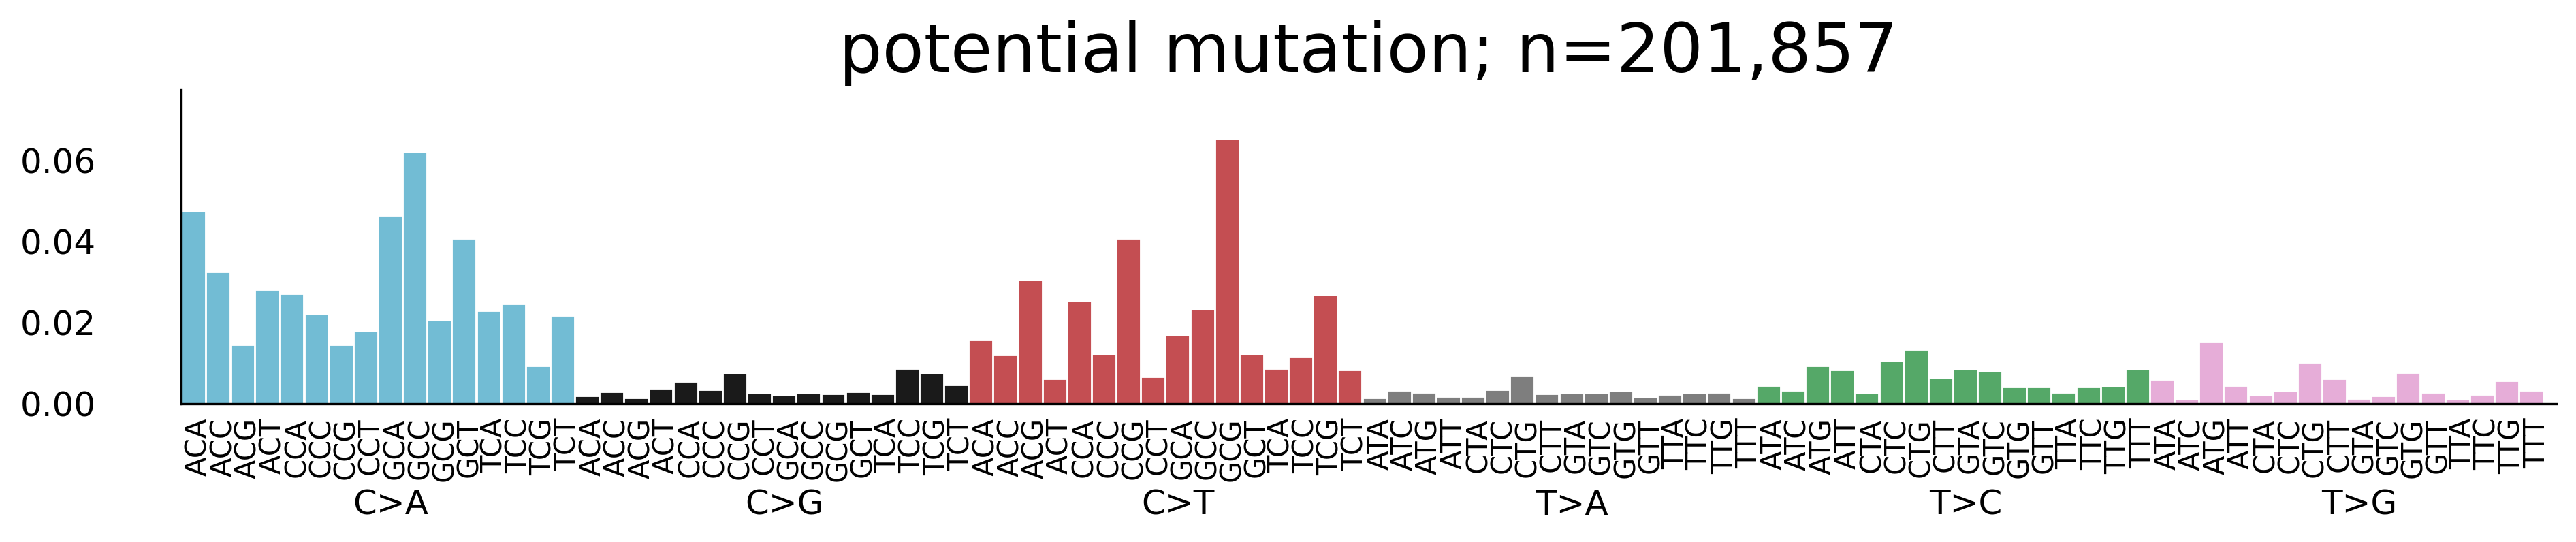

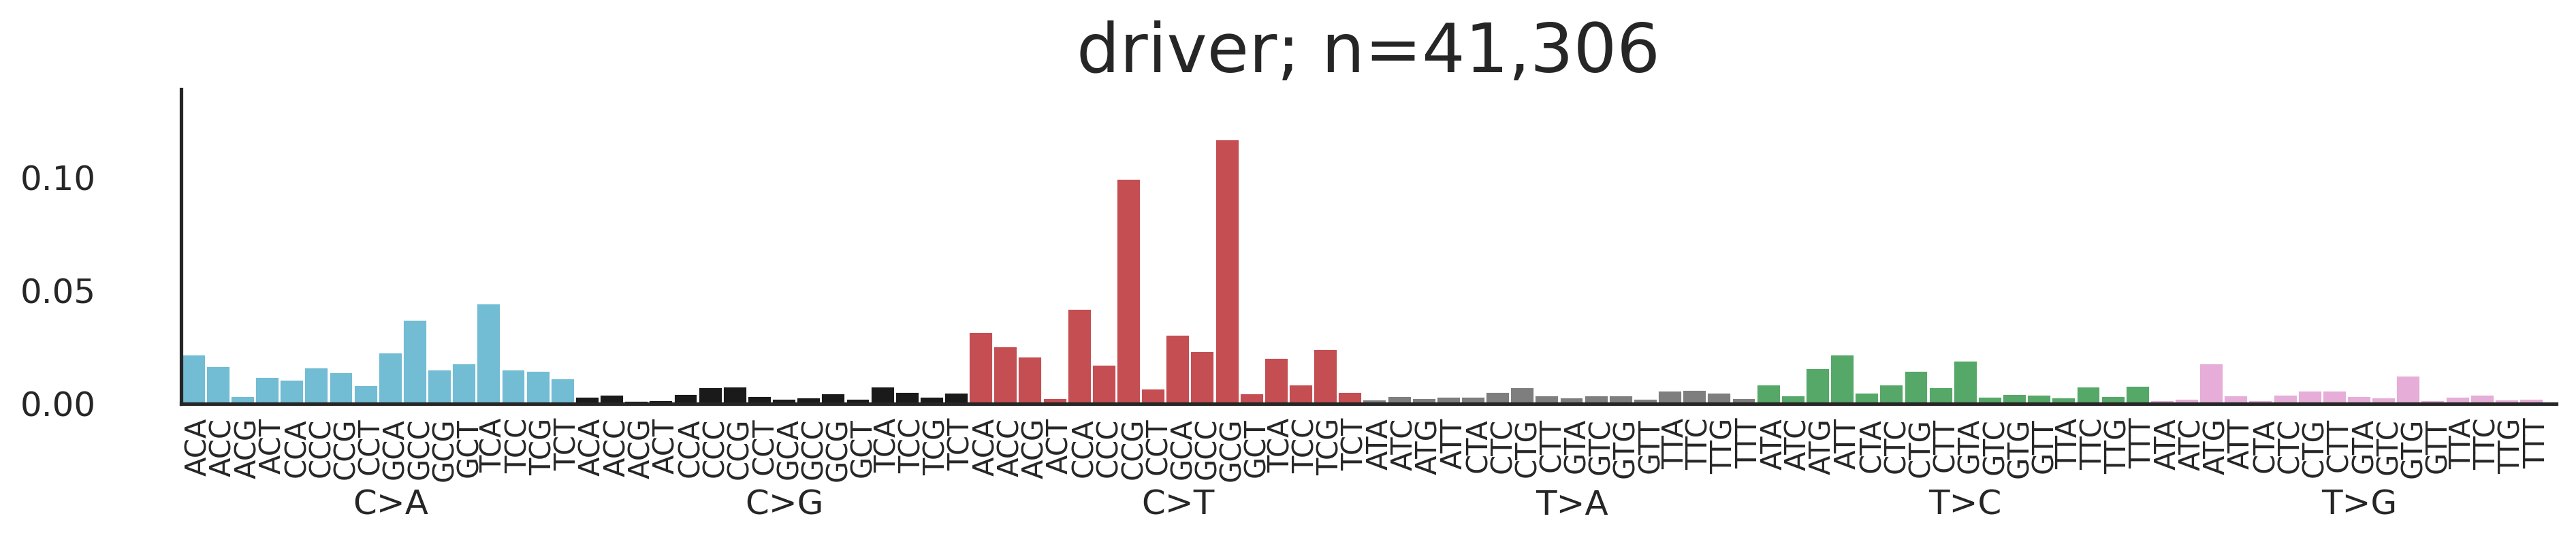

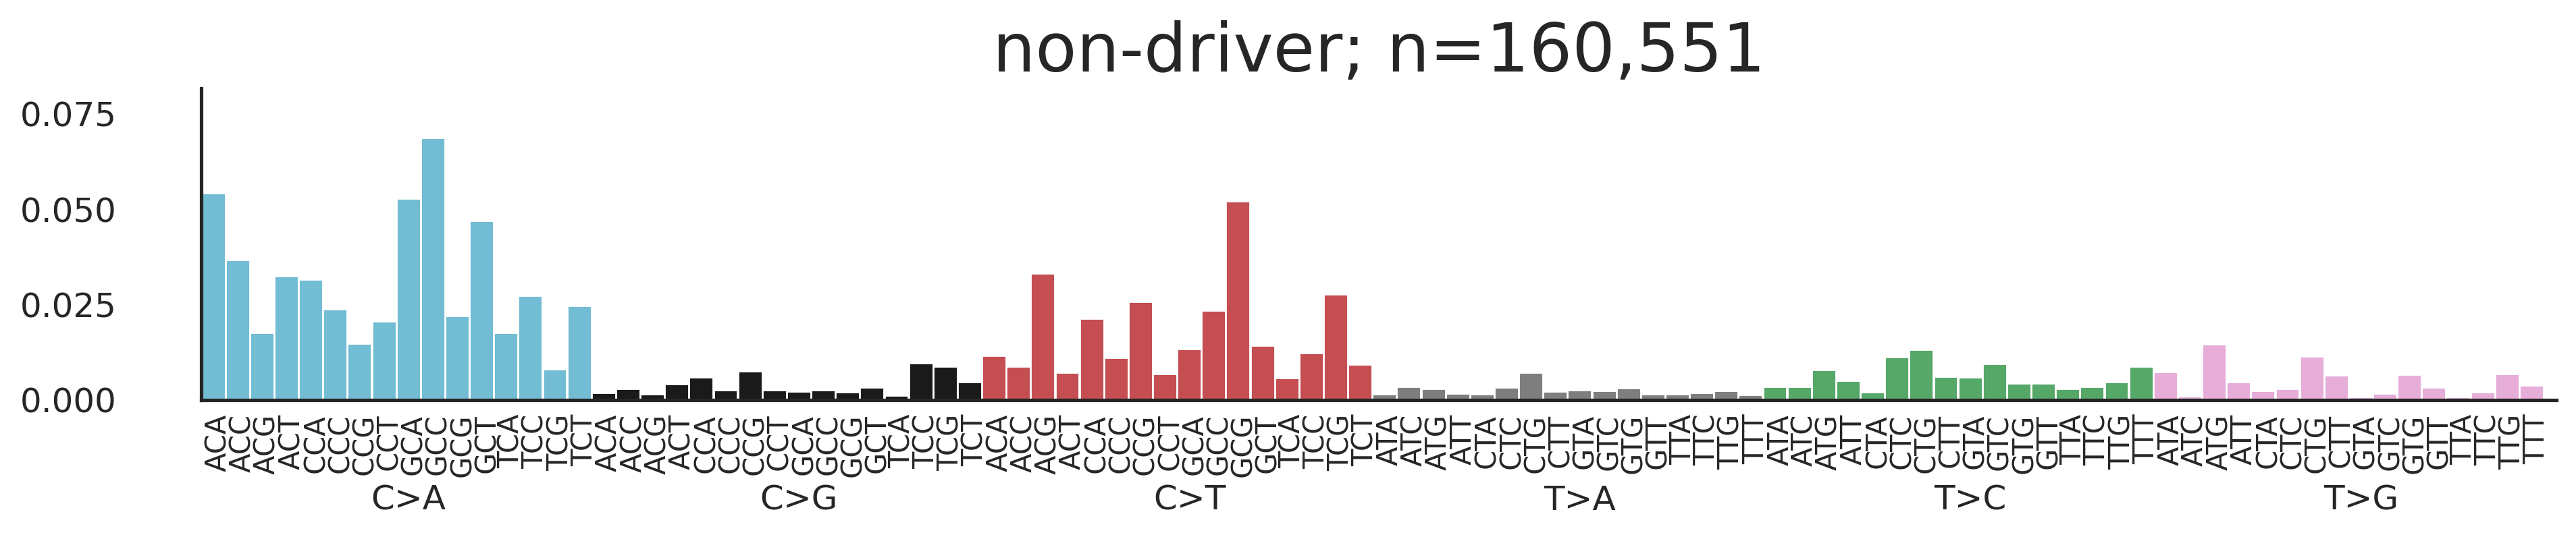

In [22]:
for cohort, profile in catalogue_dict.items():
    plot_profile(profile, title=cohort)